In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_528640/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 4
num_workers = 2

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [5]:
# Dataset
directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

test_cells = 'cell_3'


in_channels  = [[6]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (7)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 1, 'threshold': 0.0004}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'none', # Comment on what these do
                    'output_baseline_normalization': 'none',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [6]:
df = dataset.info.copy()

# df.head(10)

In [7]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[48 18 89 93 22 44 45  6 24 75 67 69 26  0  1 68 51 20 38 41 60 62 21  5
 33 59 50 28 35 25 82  9 39 88 46 90 85 16  3 12 63 15 40 14 61 17  4 49
 86 80 98]


In [8]:
# dataset.info

In [9]:
cell = 'cell_1'
frame = 10

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

dataset.out_channels

sample = dataset[idx]

210


{'mask': torch.Size([1, 512, 512]), 'weight': torch.Size([1, 512, 512]), 'input_seg': torch.Size([1, 512, 512]), 'output_seg': torch.Size([1, 512, 512]), 'input': torch.Size([1, 1, 512, 512]), 'output': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512])}


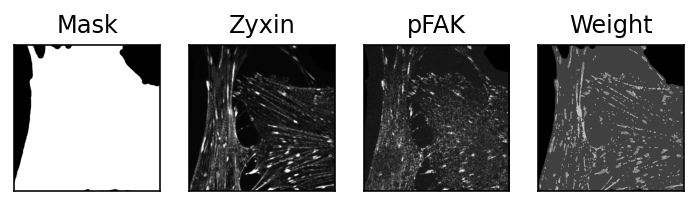

In [10]:
fig,ax=plt.subplots(1,4,figsize=(2*3, 4*2), dpi=144)

print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[2].set_title('pFAK')
ax[2].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[3].set_title('Weight')
ax[3].imshow(sample['weight'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [11]:
# sample['actin'].max()

In [12]:
# sample

### Build U-Net model with ConvNext blocks

In [13]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 1, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'aw_mse_corr',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }

n_epochs = 100

modelname = 'rerun20251209_protein1_datanormed_model_zyxin2pfak_aw_mse_corr_'+str(n_epochs)+'ep'

logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                    'image_epoch_freq': 10,
                    'image_callbacks': 'vectorfield,hists',
                    'save_model_freq': 4}

# Actually build model:
model_kwargs={
                'input_type':  'zyxin', 
                'prepend_hparams': prepend_hparams, 
                'encoder_hparams': encoder_hparams, 
                'decoder_hparams': decoder_hparams, 
                'append_hparams': append_hparams, 
                'optimizer_hparams': optimizer_hparams,
                'loss_hparams': loss_hparams,
                'logger_params': logger_params,
                'name': modelname}


model = UNet( **model_kwargs, model_idx=0)
model.to(device)


UNet(
  (layers_encode): ModuleList(
    (0): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
        (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (4): DownsampleLayer(
        (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
    )
    (1): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
        (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(8, eps=

# Perform training

In [14]:
save_models = True

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    model.reset_running_train_loss()
    model.reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        model.training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)     
    
        model.validation_step(sample, epoch=e)

    model.scheduler.step()    
    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f), loss=%0.3f"%(e, time.time()-t0, (time.time()-t0)/(e+1),model.get_running_val_loss()['aw_mse_corr_loss']))
    
    # SAVE
    if save_models:
        # Log in tensorboard
        model.log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 1:   1%|          | 64/6400.0 [04:07<4:03:10,  2.30s/it]

Epoch 0:	 Time: 247.57 	(per epoch: 247.57), loss=8.657


Epoch 2:   2%|▏         | 128/6400.0 [04:53<53:23,  1.96it/s]  

Epoch 1:	 Time: 293.19 	(per epoch: 146.59), loss=5.922


Epoch 3:   3%|▎         | 192/6400.0 [05:39<58:53,  1.76it/s]  

Epoch 2:	 Time: 339.41 	(per epoch: 113.14), loss=4.412


Epoch 4:   4%|▍         | 256/6400.0 [06:26<55:53,  1.83it/s]  

Epoch 3:	 Time: 386.28 	(per epoch: 96.57), loss=5.181


Epoch 5:   5%|▌         | 320/6400.0 [07:13<51:51,  1.95it/s]  

Epoch 4:	 Time: 433.53 	(per epoch: 86.71), loss=5.181


Epoch 6:   6%|▌         | 384/6400.0 [08:01<52:22,  1.91it/s]  

Epoch 5:	 Time: 481.28 	(per epoch: 80.21), loss=3.743


Epoch 7:   7%|▋         | 448/6400.0 [08:50<51:38,  1.92it/s]  

Epoch 6:	 Time: 530.72 	(per epoch: 75.82), loss=4.090


Epoch 8:   8%|▊         | 512/6400.0 [09:38<50:23,  1.95it/s]  

Epoch 7:	 Time: 578.87 	(per epoch: 72.36), loss=3.581


Epoch 9:   9%|▉         | 576/6400.0 [10:25<51:07,  1.90it/s]  

Epoch 8:	 Time: 625.14 	(per epoch: 69.46), loss=3.963


Epoch 10:  10%|█         | 640/6400.0 [11:14<58:44,  1.63it/s] 

Epoch 9:	 Time: 674.15 	(per epoch: 67.42), loss=3.490


Epoch 11:  11%|█         | 704/6400.0 [12:01<48:09,  1.97it/s]  

Epoch 10:	 Time: 721.78 	(per epoch: 65.62), loss=3.487


Epoch 12:  12%|█▏        | 768/6400.0 [12:50<50:34,  1.86it/s]  

Epoch 11:	 Time: 770.67 	(per epoch: 64.22), loss=3.714


Epoch 13:  13%|█▎        | 832/6400.0 [13:39<47:18,  1.96it/s]  

Epoch 12:	 Time: 819.45 	(per epoch: 63.03), loss=3.219


Epoch 14:  14%|█▍        | 896/6400.0 [14:27<46:43,  1.96it/s]  

Epoch 13:	 Time: 867.77 	(per epoch: 61.98), loss=3.809


Epoch 15:  15%|█▌        | 960/6400.0 [15:16<48:36,  1.87it/s]  

Epoch 14:	 Time: 916.10 	(per epoch: 61.07), loss=3.423


Epoch 16:  16%|█▌        | 1024/6400.0 [16:04<46:22,  1.93it/s]  

Epoch 15:	 Time: 964.01 	(per epoch: 60.25), loss=3.449


Epoch 17:  17%|█▋        | 1088/6400.0 [16:52<47:54,  1.85it/s]  

Epoch 16:	 Time: 1012.55 	(per epoch: 59.56), loss=3.041


Epoch 18:  18%|█▊        | 1152/6400.0 [17:41<46:27,  1.88it/s]  

Epoch 17:	 Time: 1061.38 	(per epoch: 58.97), loss=3.612


Epoch 19:  19%|█▉        | 1216/6400.0 [18:31<47:55,  1.80it/s]  

Epoch 18:	 Time: 1110.98 	(per epoch: 58.47), loss=4.138


Epoch 20:  20%|██        | 1280/6400.0 [19:20<44:36,  1.91it/s]  

Epoch 19:	 Time: 1160.62 	(per epoch: 58.03), loss=3.541


Epoch 21:  21%|██        | 1344/6400.0 [20:09<45:03,  1.87it/s]  

Epoch 20:	 Time: 1209.10 	(per epoch: 57.58), loss=3.465


Epoch 22:  22%|██▏       | 1408/6400.0 [20:57<43:33,  1.91it/s]  

Epoch 21:	 Time: 1257.82 	(per epoch: 57.17), loss=2.926


Epoch 23:  23%|██▎       | 1472/6400.0 [21:46<43:29,  1.89it/s]  

Epoch 22:	 Time: 1306.43 	(per epoch: 56.80), loss=3.212


Epoch 24:  24%|██▍       | 1536/6400.0 [22:34<43:36,  1.86it/s]  

Epoch 23:	 Time: 1354.26 	(per epoch: 56.43), loss=3.961


Epoch 25:  25%|██▌       | 1600/6400.0 [23:23<42:51,  1.87it/s]  

Epoch 24:	 Time: 1403.17 	(per epoch: 56.13), loss=3.493


Epoch 26:  26%|██▌       | 1664/6400.0 [24:11<40:49,  1.93it/s]  

Epoch 25:	 Time: 1451.66 	(per epoch: 55.83), loss=2.850


Epoch 27:  27%|██▋       | 1728/6400.0 [24:57<37:17,  2.09it/s]  

Epoch 26:	 Time: 1497.35 	(per epoch: 55.46), loss=3.045


Epoch 28:  28%|██▊       | 1792/6400.0 [25:39<36:30,  2.10it/s]  

Epoch 27:	 Time: 1539.40 	(per epoch: 54.98), loss=3.338


Epoch 29:  29%|██▉       | 1856/6400.0 [26:22<34:23,  2.20it/s]  

Epoch 28:	 Time: 1582.06 	(per epoch: 54.55), loss=2.953


Epoch 30:  30%|███       | 1920/6400.0 [27:04<36:32,  2.04it/s]  

Epoch 29:	 Time: 1624.98 	(per epoch: 54.17), loss=3.119


Epoch 31:  31%|███       | 1984/6400.0 [27:48<36:39,  2.01it/s]  

Epoch 30:	 Time: 1668.10 	(per epoch: 53.81), loss=3.077


Epoch 32:  32%|███▏      | 2048/6400.0 [28:29<47:37,  1.52it/s]  

Epoch 31:	 Time: 1709.97 	(per epoch: 53.44), loss=2.887


Epoch 33:  33%|███▎      | 2112/6400.0 [29:12<33:34,  2.13it/s]  

Epoch 32:	 Time: 1752.84 	(per epoch: 53.12), loss=2.777


Epoch 34:  34%|███▍      | 2176/6400.0 [29:55<32:29,  2.17it/s]  

Epoch 33:	 Time: 1795.32 	(per epoch: 52.80), loss=3.122


Epoch 35:  35%|███▌      | 2240/6400.0 [30:38<32:55,  2.11it/s]  

Epoch 34:	 Time: 1838.05 	(per epoch: 52.52), loss=2.855


Epoch 36:  36%|███▌      | 2304/6400.0 [31:20<32:35,  2.09it/s]  

Epoch 35:	 Time: 1880.50 	(per epoch: 52.24), loss=2.783


Epoch 37:  37%|███▋      | 2368/6400.0 [32:02<32:18,  2.08it/s]  

Epoch 36:	 Time: 1922.85 	(per epoch: 51.97), loss=2.793


Epoch 38:  38%|███▊      | 2432/6400.0 [32:45<32:02,  2.06it/s]  

Epoch 37:	 Time: 1965.67 	(per epoch: 51.73), loss=2.789


Epoch 39:  39%|███▉      | 2496/6400.0 [33:27<30:43,  2.12it/s]  

Epoch 38:	 Time: 2007.26 	(per epoch: 51.47), loss=2.777


Epoch 40:  40%|████      | 2560/6400.0 [34:09<30:23,  2.11it/s]  

Epoch 39:	 Time: 2049.14 	(per epoch: 51.23), loss=2.930


Epoch 41:  41%|████      | 2624/6400.0 [34:51<30:31,  2.06it/s]  

Epoch 40:	 Time: 2091.38 	(per epoch: 51.01), loss=2.928


Epoch 42:  42%|████▏     | 2688/6400.0 [35:35<30:27,  2.03it/s]  

Epoch 41:	 Time: 2135.82 	(per epoch: 50.85), loss=2.924


Epoch 43:  43%|████▎     | 2752/6400.0 [36:18<30:08,  2.02it/s]  

Epoch 42:	 Time: 2178.78 	(per epoch: 50.67), loss=3.107


Epoch 44:  44%|████▍     | 2816/6400.0 [37:01<28:17,  2.11it/s]  

Epoch 43:	 Time: 2221.75 	(per epoch: 50.49), loss=2.934


Epoch 45:  45%|████▌     | 2880/6400.0 [37:44<27:37,  2.12it/s]  

Epoch 44:	 Time: 2264.58 	(per epoch: 50.32), loss=2.895


Epoch 46:  46%|████▌     | 2944/6400.0 [38:27<28:06,  2.05it/s]  

Epoch 45:	 Time: 2307.19 	(per epoch: 50.16), loss=2.844


Epoch 47:  47%|████▋     | 3008/6400.0 [39:09<26:01,  2.17it/s]  

Epoch 46:	 Time: 2349.35 	(per epoch: 49.99), loss=2.831


Epoch 48:  48%|████▊     | 3072/6400.0 [39:52<27:08,  2.04it/s]  

Epoch 47:	 Time: 2392.12 	(per epoch: 49.84), loss=2.825


Epoch 49:  49%|████▉     | 3136/6400.0 [40:34<25:36,  2.12it/s]  

Epoch 48:	 Time: 2433.99 	(per epoch: 49.67), loss=2.774


Epoch 50:  50%|█████     | 3200/6400.0 [41:17<25:01,  2.13it/s]  

Epoch 49:	 Time: 2477.60 	(per epoch: 49.55), loss=3.426


Epoch 51:  51%|█████     | 3264/6400.0 [42:00<24:49,  2.11it/s]  

Epoch 50:	 Time: 2520.28 	(per epoch: 49.42), loss=2.704


Epoch 52:  52%|█████▏    | 3328/6400.0 [42:43<24:35,  2.08it/s]  

Epoch 51:	 Time: 2563.31 	(per epoch: 49.29), loss=2.723


Epoch 53:  53%|█████▎    | 3392/6400.0 [43:25<22:57,  2.18it/s]  

Epoch 52:	 Time: 2605.75 	(per epoch: 49.17), loss=2.692


Epoch 54:  54%|█████▍    | 3456/6400.0 [44:08<23:09,  2.12it/s]  

Epoch 53:	 Time: 2648.57 	(per epoch: 49.05), loss=2.834


Epoch 55:  55%|█████▌    | 3520/6400.0 [44:50<22:05,  2.17it/s]  

Epoch 54:	 Time: 2690.85 	(per epoch: 48.92), loss=2.840


Epoch 56:  56%|█████▌    | 3584/6400.0 [45:33<22:27,  2.09it/s]  

Epoch 55:	 Time: 2733.03 	(per epoch: 48.80), loss=2.656


Epoch 57:  57%|█████▋    | 3648/6400.0 [46:15<21:30,  2.13it/s]  

Epoch 56:	 Time: 2775.10 	(per epoch: 48.69), loss=2.684


Epoch 58:  58%|█████▊    | 3712/6400.0 [46:57<21:17,  2.10it/s]  

Epoch 57:	 Time: 2817.49 	(per epoch: 48.58), loss=2.666


Epoch 59:  59%|█████▉    | 3776/6400.0 [47:41<22:08,  1.97it/s]  

Epoch 58:	 Time: 2861.69 	(per epoch: 48.50), loss=2.731


Epoch 60:  60%|██████    | 3840/6400.0 [48:24<20:08,  2.12it/s]  

Epoch 59:	 Time: 2903.98 	(per epoch: 48.40), loss=2.882


Epoch 61:  61%|██████    | 3904/6400.0 [49:06<19:43,  2.11it/s]  

Epoch 60:	 Time: 2946.70 	(per epoch: 48.31), loss=2.998


Epoch 62:  62%|██████▏   | 3968/6400.0 [49:48<19:21,  2.09it/s]  

Epoch 61:	 Time: 2988.90 	(per epoch: 48.21), loss=2.823


Epoch 63:  63%|██████▎   | 4032/6400.0 [50:31<18:08,  2.17it/s]  

Epoch 62:	 Time: 3031.07 	(per epoch: 48.11), loss=2.721


Epoch 64:  64%|██████▍   | 4096/6400.0 [51:13<17:56,  2.14it/s]  

Epoch 63:	 Time: 3073.35 	(per epoch: 48.02), loss=2.745


Epoch 65:  65%|██████▌   | 4160/6400.0 [51:55<17:41,  2.11it/s]  

Epoch 64:	 Time: 3115.18 	(per epoch: 47.93), loss=2.496


Epoch 66:  66%|██████▌   | 4224/6400.0 [52:37<16:34,  2.19it/s]  

Epoch 65:	 Time: 3157.76 	(per epoch: 47.84), loss=2.911


Epoch 67:  67%|██████▋   | 4288/6400.0 [53:19<16:28,  2.14it/s]  

Epoch 66:	 Time: 3199.97 	(per epoch: 47.76), loss=2.830


Epoch 68:  68%|██████▊   | 4352/6400.0 [54:03<16:46,  2.04it/s]  

Epoch 67:	 Time: 3243.68 	(per epoch: 47.70), loss=2.819


Epoch 69:  69%|██████▉   | 4416/6400.0 [54:46<15:33,  2.12it/s]  

Epoch 68:	 Time: 3286.31 	(per epoch: 47.63), loss=2.611


Epoch 70:  70%|███████   | 4480/6400.0 [55:28<15:39,  2.04it/s]  

Epoch 69:	 Time: 3328.57 	(per epoch: 47.55), loss=2.520


Epoch 71:  71%|███████   | 4544/6400.0 [56:11<15:11,  2.04it/s]  

Epoch 70:	 Time: 3371.19 	(per epoch: 47.48), loss=2.705


Epoch 72:  72%|███████▏  | 4608/6400.0 [56:53<14:14,  2.10it/s]  

Epoch 71:	 Time: 3413.65 	(per epoch: 47.41), loss=2.666


Epoch 73:  73%|███████▎  | 4672/6400.0 [57:35<13:40,  2.11it/s]  

Epoch 72:	 Time: 3455.94 	(per epoch: 47.34), loss=2.944


Epoch 74:  74%|███████▍  | 4736/6400.0 [58:19<12:50,  2.16it/s]  

Epoch 73:	 Time: 3499.14 	(per epoch: 47.29), loss=2.423


Epoch 75:  75%|███████▌  | 4800/6400.0 [59:03<12:57,  2.06it/s]  

Epoch 74:	 Time: 3543.01 	(per epoch: 47.24), loss=3.121


Epoch 76:  76%|███████▌  | 4864/6400.0 [59:46<12:13,  2.09it/s]  

Epoch 75:	 Time: 3586.93 	(per epoch: 47.20), loss=2.462


Epoch 77:  77%|███████▋  | 4928/6400.0 [1:00:29<11:36,  2.11it/s]

Epoch 76:	 Time: 3629.28 	(per epoch: 47.13), loss=2.715


Epoch 78:  78%|███████▊  | 4992/6400.0 [1:01:12<10:48,  2.17it/s]  

Epoch 77:	 Time: 3672.01 	(per epoch: 47.08), loss=2.570


Epoch 79:  79%|███████▉  | 5056/6400.0 [1:01:53<10:45,  2.08it/s]  

Epoch 78:	 Time: 3713.75 	(per epoch: 47.01), loss=2.762


Epoch 80:  80%|████████  | 5120/6400.0 [1:02:35<10:04,  2.12it/s]  

Epoch 79:	 Time: 3755.86 	(per epoch: 46.95), loss=2.533


Epoch 81:  81%|████████  | 5184/6400.0 [1:03:18<09:18,  2.18it/s]  

Epoch 80:	 Time: 3797.96 	(per epoch: 46.89), loss=3.040


Epoch 82:  82%|████████▏ | 5248/6400.0 [1:03:59<09:08,  2.10it/s]

Epoch 81:	 Time: 3839.74 	(per epoch: 46.83), loss=2.496


Epoch 83:  83%|████████▎ | 5312/6400.0 [1:04:42<08:49,  2.06it/s]

Epoch 82:	 Time: 3882.25 	(per epoch: 46.77), loss=3.033


Epoch 84:  84%|████████▍ | 5376/6400.0 [1:05:25<08:08,  2.10it/s]

Epoch 83:	 Time: 3925.13 	(per epoch: 46.73), loss=2.407


Epoch 85:  85%|████████▌ | 5440/6400.0 [1:06:07<07:43,  2.07it/s]

Epoch 84:	 Time: 3967.84 	(per epoch: 46.68), loss=2.628


Epoch 86:  86%|████████▌ | 5504/6400.0 [1:06:51<07:00,  2.13it/s]

Epoch 85:	 Time: 4010.99 	(per epoch: 46.64), loss=2.644


Epoch 87:  87%|████████▋ | 5568/6400.0 [1:07:33<06:31,  2.13it/s]

Epoch 86:	 Time: 4053.92 	(per epoch: 46.60), loss=2.930


Epoch 88:  88%|████████▊ | 5632/6400.0 [1:08:16<06:09,  2.08it/s]

Epoch 87:	 Time: 4096.57 	(per epoch: 46.55), loss=2.788


Epoch 89:  89%|████████▉ | 5696/6400.0 [1:08:58<05:26,  2.15it/s]

Epoch 88:	 Time: 4138.86 	(per epoch: 46.50), loss=2.595


Epoch 90:  90%|█████████ | 5760/6400.0 [1:09:40<05:05,  2.09it/s]

Epoch 89:	 Time: 4180.84 	(per epoch: 46.45), loss=2.518


Epoch 91:  91%|█████████ | 5824/6400.0 [1:10:23<04:38,  2.07it/s]

Epoch 90:	 Time: 4223.15 	(per epoch: 46.41), loss=2.564


Epoch 92:  92%|█████████▏| 5888/6400.0 [1:11:05<03:52,  2.20it/s]

Epoch 91:	 Time: 4265.46 	(per epoch: 46.36), loss=2.846


Epoch 93:  93%|█████████▎| 5952/6400.0 [1:11:47<03:24,  2.19it/s]

Epoch 92:	 Time: 4307.40 	(per epoch: 46.32), loss=3.029


Epoch 94:  94%|█████████▍| 6016/6400.0 [1:12:30<03:01,  2.11it/s]

Epoch 93:	 Time: 4350.13 	(per epoch: 46.28), loss=2.829


Epoch 95:  95%|█████████▌| 6080/6400.0 [1:13:12<02:28,  2.15it/s]

Epoch 94:	 Time: 4392.71 	(per epoch: 46.24), loss=3.055


Epoch 96:  96%|█████████▌| 6144/6400.0 [1:13:55<02:04,  2.06it/s]

Epoch 95:	 Time: 4435.01 	(per epoch: 46.20), loss=2.513


Epoch 97:  97%|█████████▋| 6208/6400.0 [1:14:37<01:27,  2.19it/s]

Epoch 96:	 Time: 4477.44 	(per epoch: 46.16), loss=2.725


Epoch 98:  98%|█████████▊| 6272/6400.0 [1:15:19<01:01,  2.09it/s]

Epoch 97:	 Time: 4519.54 	(per epoch: 46.12), loss=2.553


Epoch 99:  99%|█████████▉| 6336/6400.0 [1:16:02<00:29,  2.14it/s]

Epoch 98:	 Time: 4562.37 	(per epoch: 46.08), loss=2.523


Epoch 99: 100%|██████████| 6400/6400.0 [1:16:37<00:00,  2.11it/s]

Epoch 99:	 Time: 4604.64 	(per epoch: 46.05), loss=2.663


In [15]:
sample['actin'].sum

<function Tensor.sum>

### Plot prediction on train cell

In [16]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input2_0_mean)
    return corr_norm


In [28]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

prediction_result_folder = '../zyxin2pfak_results/'

if not os.path.isdir(prediction_result_folder):          
    os.mkdir(prediction_result_folder)

model_prediction_result_folder = '../zyxin2pfak_results/' +modelname + '/'

if not os.path.isdir(model_prediction_result_folder):          
    os.mkdir(model_prediction_result_folder)


plot_result_folder = model_prediction_result_folder +'plot'
tiff_result_folder = model_prediction_result_folder +'tiff'

if not os.path.isdir(plot_result_folder):          
    os.mkdir(plot_result_folder)

if not os.path.isdir(tiff_result_folder):          
    os.mkdir(tiff_result_folder)


eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 1024
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)




pred_corr_df = pd.DataFrame(columns=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])


for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(10):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()

        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[dilate_mask>0]


        z_p_corr = normcorr(zyxin_values,pfak_values)
        z_n_corr = normcorr(zyxin_values,nn_values)
        p_n_corr = normcorr(pfak_values,nn_values)
        z_z_corr = normcorr(zyxin_values,zyxin_values)
        p_p_corr = normcorr(pfak_values,pfak_values)
        
        train_test_flag= 'train'
        if cell == 'cell_3' or cell == 'cell_6' :
            train_test_flag= 'test'

        s = pd.Series([cell, frame, train_test_flag,z_p_corr,z_n_corr,p_n_corr],
                        index=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])
        pred_corr_df = pred_corr_df._append(s,ignore_index=True)

        pred_corr_df.to_csv(os.path.join(model_prediction_result_folder,modelname+'z2p_prediction_300epochs_corr.csv'))

        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=1, vmin=0)
        if cell == 'cell_3' or cell == 'cell_6' :
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('pFAK-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=1, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('pFAK-NN')
        ax[2].imshow(pred.squeeze()*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        ax[2].set_xlabel('zp'+ "%.2f" % (z_p_corr) +',zn'+ "%.2f" % (z_n_corr) +',pn'+ "%.2f" % (p_n_corr))#+',zz'+ "%.2f" % (z_z_corr)+',pp'+ "%.2f" % (p_p_corr))

        tifffile.imsave(os.path.join(tiff_result_folder,cell + '_frame'+str(frame)+'.tif'),pred.squeeze()/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join(plot_result_folder, cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 


{'crop_size': 1024, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


In [18]:
model(model.select_inputs(model.input_type, sample)).shape

torch.Size([1, 1, 1024, 1024])

In [19]:
zyxin_values = zyx[dilate_mask>0]
pfak_values = pax[dilate_mask>0]
nn_values = pred[dilate_mask>0]

In [20]:
np.mean(zyxin_values)

0.08037461

In [21]:
pax.mean()

0.04609237

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}
torch.Size([1, 1, 960, 960])
(1, 1, 960, 960)


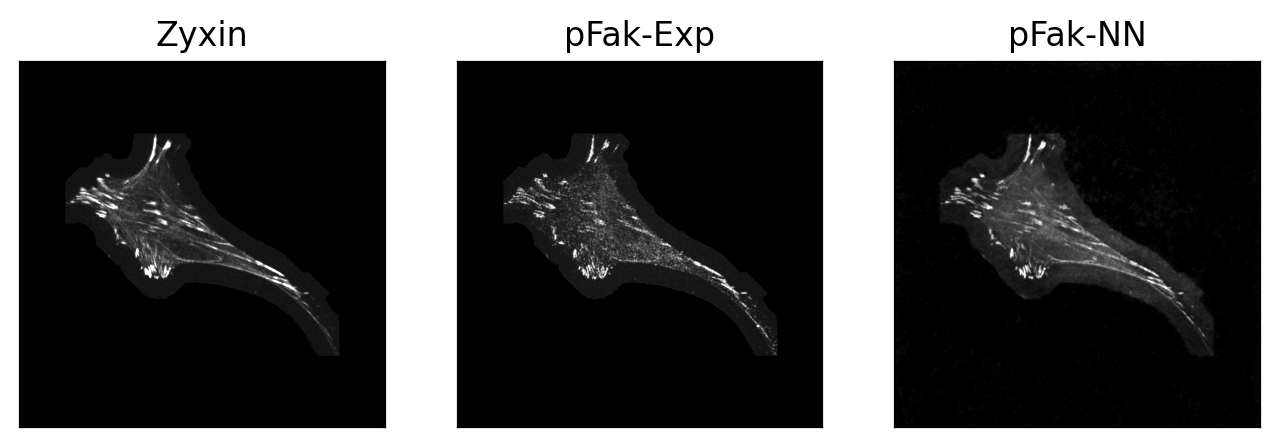

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 5


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=0.3, vmin=0)

ax[1].set_title('pFak-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('pFak-NN')
ax[2].imshow(pred.squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

### Performance on test cell

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}
torch.Size([1, 1, 960, 960])
(1, 1, 960, 960)


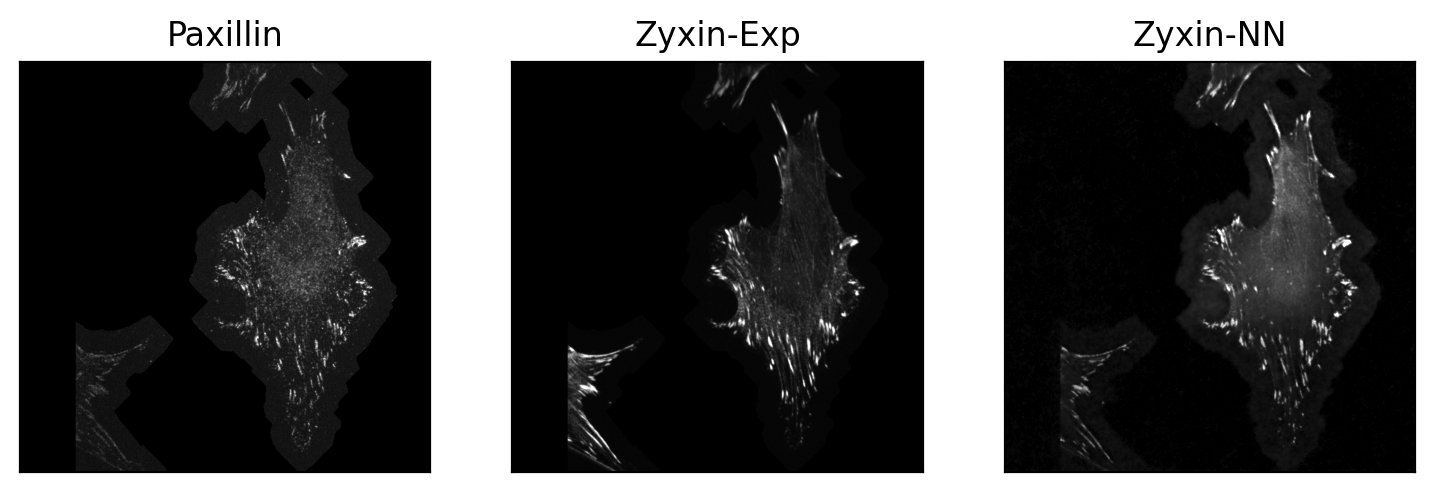

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)


eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 250

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])